In [1]:
import os
from datetime import datetime
info = os.stat("/content/drive/MyDrive/NeuroOnco/TEMP/patches_dataset.npz")
print("📅 Ultima modifica:", datetime.fromtimestamp(info.st_mtime))


📅 Ultima modifica: 2025-05-28 21:15:32


In [2]:
# 📦 Setup
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt

# 📂 Path al file npz
DATA_PATH = "/content/drive/MyDrive/NeuroOnco/TEMP/patches_dataset.npz"
N_CLASSES = 2
BATCH_SIZE = 2048
EPOCHS = 100
LEARNING_RATE = 1e-3
VAL_SPLIT = 0.2

# ✅ Verifica GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🖥️ Using device: {device}")

🖥️ Using device: cuda


In [3]:
# 📊 Caricamento dati
data = np.load(DATA_PATH)
X = data["patches"]
y = data["labels"]

# 📚 Lista dei nomi delle serie (ordine corrispondente ai canali di X)
SERIES_NAMES = ["t1w", "flair", "dwi", "ktran", "cbv", "apt"]

# ✍️ Serie che voglio usare per l'addestramento (modifica qui per cambiare input)
SELECTED_SERIES = [ "t1w", "flair", "dwi", "ktran", "cbv", "apt"]  # esempio

# 🔍 Ricava gli indici a partire dai nomi
SELECTED_CHANNELS = [SERIES_NAMES.index(name) for name in SELECTED_SERIES]

# 🔀 Applica la selezione
X = X[:, SELECTED_CHANNELS, :, :, :]
print(f"✅ Serie selezionate: {SELECTED_SERIES} | Indici: {SELECTED_CHANNELS} | Nuova shape: {X.shape}")


print("✅ Dataset loaded:", X.shape, y.shape)

✅ Serie selezionate: ['t1w', 'flair', 'dwi', 'ktran', 'cbv', 'apt'] | Indici: [0, 1, 2, 3, 4, 5] | Nuova shape: (18493, 6, 5, 5, 5)
✅ Dataset loaded: (18493, 6, 5, 5, 5) (18493,)


In [4]:
print("📂 File caricato da:", DATA_PATH)
print("🔍 Controllo shape patch:", X.shape, "| Classi:", np.unique(y, return_counts=True))


📂 File caricato da: /content/drive/MyDrive/NeuroOnco/TEMP/patches_dataset.npz
🔍 Controllo shape patch: (18493, 6, 5, 5, 5) | Classi: (array([0, 1], dtype=uint8), array([8590, 9903]))


In [5]:
# 🧹 Normalizzazione (opzionale, utile se range ≠ [0,1])
X = X.astype(np.float32)
if np.nanmax(X) > 1.5:
    X = X / np.nanmax(X)


In [6]:
#📚 Dataset custom
class PatchDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# 🧱 Modello CNN 3D semplice
# 🧱 Modello CNN 3D semplice
class CNN3D(nn.Module):
    def __init__(self, in_channels, n_classes=2):
        super(CNN3D, self).__init__()

        self.block1 = nn.Sequential(
            nn.Conv3d(in_channels, 32, kernel_size=3, padding=1),
            nn.BatchNorm3d(32),
            nn.ReLU(),
            nn.MaxPool3d(2),
            nn.Dropout3d(0.2)
        )

        self.block2 = nn.Sequential(
            nn.Conv3d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(),
            nn.MaxPool3d(2),
            nn.Dropout3d(0.3)
        )

        self.block3 = nn.Sequential(
            nn.Conv3d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm3d(128),
            nn.ReLU(),
            nn.AdaptiveAvgPool3d(1)
        )

        self.fc = nn.Linear(128, n_classes)

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = torch.flatten(x, 1)
        return self.fc(x)


In [7]:
# 🧪 Split e dataloader
dataset = PatchDataset(X, y)
val_size = int(len(dataset) * VAL_SPLIT)
train_size = len(dataset) - val_size
train_set, val_set = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE)

In [8]:
# 🚀 Istanzia modello
model = CNN3D(in_channels=len(SELECTED_SERIES), n_classes=N_CLASSES).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
class_counts = np.bincount(y)
weights = 1.0 / torch.tensor(class_counts, dtype=torch.float32)
weights = weights / weights.sum()
criterion = nn.CrossEntropyLoss(weight=weights.to(device))


In [9]:
# 📉 Training loop
train_losses, val_losses = [], []

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_losses.append(running_loss / len(train_loader))

    model.eval()
    val_loss = 0
    y_true, y_pred, y_prob = [], [], []
    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            val_loss += loss.item()

            preds = outputs.argmax(dim=1)
            probs = F.softmax(outputs, dim=1)[:, 1]

            y_true.extend(batch_y.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            y_prob.extend(probs.cpu().numpy())

    val_losses.append(val_loss / len(val_loader))
    acc = np.mean(np.array(y_pred) == np.array(y_true))
    tqdm_msg = f"📦 Epoch {epoch+1}/{EPOCHS} | Train Loss: {train_losses[-1]:.4f} | Val Loss: {val_losses[-1]:.4f} | Val Acc: {acc:.4f}"
    print(tqdm_msg)

📦 Epoch 1/100 | Train Loss: 0.3813 | Val Loss: 0.6201 | Val Acc: 0.9248
📦 Epoch 2/100 | Train Loss: 0.2235 | Val Loss: 0.5018 | Val Acc: 0.8085
📦 Epoch 3/100 | Train Loss: 0.1969 | Val Loss: 0.3321 | Val Acc: 0.9113
📦 Epoch 4/100 | Train Loss: 0.1741 | Val Loss: 0.2574 | Val Acc: 0.8997
📦 Epoch 5/100 | Train Loss: 0.1593 | Val Loss: 0.2217 | Val Acc: 0.9108
📦 Epoch 6/100 | Train Loss: 0.1474 | Val Loss: 0.2121 | Val Acc: 0.9145
📦 Epoch 7/100 | Train Loss: 0.1415 | Val Loss: 0.1905 | Val Acc: 0.9197
📦 Epoch 8/100 | Train Loss: 0.1271 | Val Loss: 0.1737 | Val Acc: 0.9329
📦 Epoch 9/100 | Train Loss: 0.1256 | Val Loss: 0.1301 | Val Acc: 0.9454
📦 Epoch 10/100 | Train Loss: 0.1163 | Val Loss: 0.1455 | Val Acc: 0.9427
📦 Epoch 11/100 | Train Loss: 0.1109 | Val Loss: 0.1075 | Val Acc: 0.9532
📦 Epoch 12/100 | Train Loss: 0.1061 | Val Loss: 0.0940 | Val Acc: 0.9673
📦 Epoch 13/100 | Train Loss: 0.1062 | Val Loss: 0.1014 | Val Acc: 0.9594
📦 Epoch 14/100 | Train Loss: 0.1031 | Val Loss: 0.1087 | Val

In [10]:
# 💾 Salvataggio modello e metadati
MODEL_PATH = "/content/drive/MyDrive/NeuroOnco/Modello/cnn_model_with_series.pt"

PATCH_SIZE = X.shape[2:]  # (Z, Y, X)

torch.save({
    'model_state_dict': model.state_dict(),
    'selected_series': SELECTED_SERIES,
    'series_names': SERIES_NAMES,
    'input_shape': X.shape[1:],   # (C, Z, Y, X)
    'patch_size': PATCH_SIZE,     # ✅ Aggiunto
}, MODEL_PATH)

print(f"✅ Modello salvato in: {MODEL_PATH}")
print(f"🧠 Serie usate per l’addestramento: {SELECTED_SERIES}")
print(f"📐 Dimensione patch salvata: {PATCH_SIZE}")


✅ Modello salvato in: /content/drive/MyDrive/NeuroOnco/Modello/cnn_model_with_series.pt
🧠 Serie usate per l’addestramento: ['t1w', 'flair', 'dwi', 'ktran', 'cbv', 'apt']
📐 Dimensione patch salvata: (5, 5, 5)


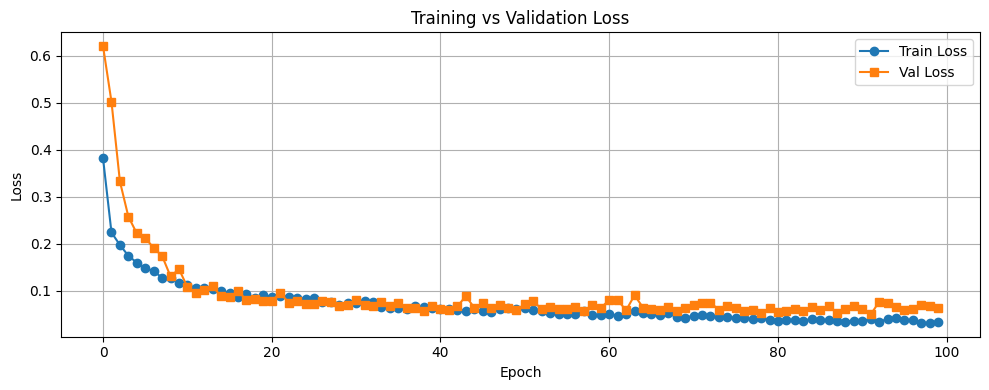

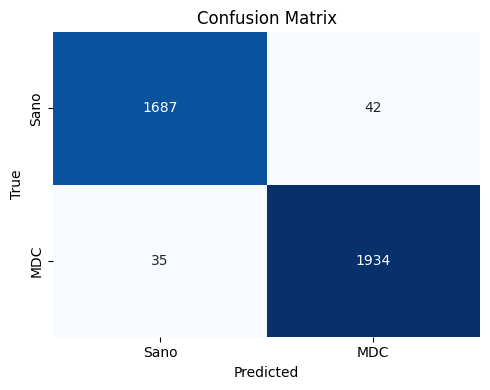

<ipython-input-11-4901235cc3d8>:60: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


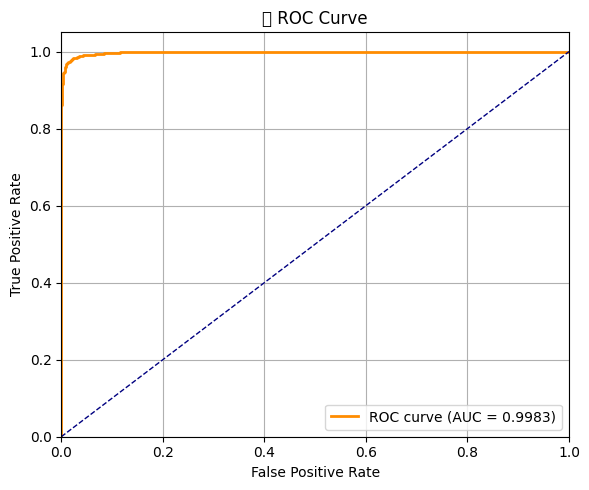

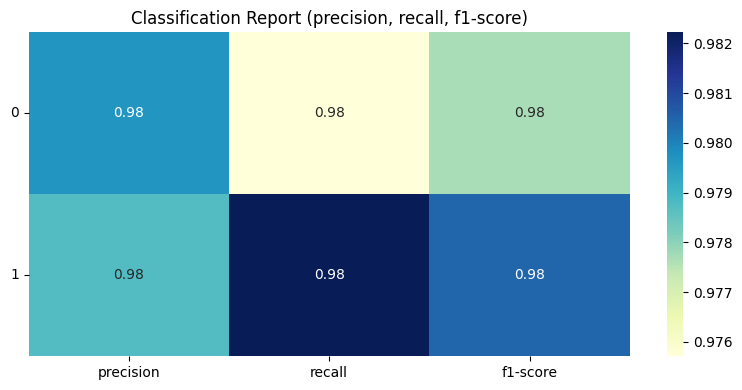

📝 Classification Report (tabellare):


,precision,recall,f1-score,support
0,0.9797,0.9757,0.9777,1729.0000
1,0.9787,0.9822,0.9805,1969.0000
accuracy,0.9792,0.9792,0.9792,0.9792
macro avg,0.9792,0.9790,0.9791,3698.0000
weighted avg,0.9792,0.9792,0.9792,3698.0000



🎯 ROC AUC = 0.9983


In [11]:
# ✅ Import mancanti
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import seaborn as sns
import pandas as pd

# 📋 Classification Report come DataFrame
report_dict = classification_report(y_true, y_pred, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()

# 🎯 ROC AUC
try:
    auc = roc_auc_score(y_true, y_prob)
    auc_text = f"ROC AUC = {auc:.4f}"
except:
    auc = None
    auc_text = "ROC AUC not available"

# 📊 Confusion Matrix
conf_mat = confusion_matrix(y_true, y_pred)

# 📈 Plot 1: Training Curve
plt.figure(figsize=(10, 4))
plt.plot(train_losses, label="Train Loss", marker='o')
plt.plot(val_losses, label="Val Loss", marker='s')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 📈 Plot 2: Confusion Matrix
plt.figure(figsize=(5, 4))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=["Sano", "MDC"], yticklabels=["Sano", "MDC"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

from sklearn.metrics import roc_curve, auc

# ✅ Calcolo ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_prob)
roc_auc = auc(fpr, tpr)

# 📈 Plot curva ROC
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("📈 ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


# 📈 Plot 3: Classification Report
plt.figure(figsize=(8, 4))
sns.heatmap(report_df.iloc[:2, :-1], annot=True, cmap='YlGnBu', fmt=".2f")
plt.title("Classification Report (precision, recall, f1-score)")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# ✅ Report tabellare in chiaro
print("📝 Classification Report (tabellare):")
display(report_df.round(4))
print(f"\n🎯 {auc_text}")


In [12]:
# 🔍 TEST DIRETTO SU PATCH USATE IN TRAINING

print("\n🧪 TEST SU PATCH ORIGINALI DAL DATASET")

# ⚠️ Ripeti la selezione canali come fatto in addestramento
X_test = data["patches"][:, SELECTED_CHANNELS, :, :, :]
y_test = data["labels"]

# 🔁 Applica normalizzazione se era usata nel training
X_test = X_test.astype(np.float32)
if np.nanmax(X_test) > 1.5:
    X_test = X_test / np.nanmax(X_test)

# 🎯 Seleziona 10 patch malate e 10 sane
idx_malato = np.where(y_test == 1)[0][:10]
idx_sano = np.where(y_test == 0)[0][:10]
idx_tot = np.concatenate([idx_malato, idx_sano])
X_subset = torch.tensor(X_test[idx_tot], dtype=torch.float32).to(device)
y_subset = y_test[idx_tot]

# 🔁 Inference
model.eval()
with torch.no_grad():
    logits = model(X_subset)
    probs = F.softmax(logits, dim=1)[:, 1].cpu().numpy()

# 📊 Stampa risultati
for i, (p, label) in enumerate(zip(probs, y_subset)):
    print(f"Patch {i:2d} | True: {label} | Prob MALATO: {p:.4f}")



🧪 TEST SU PATCH ORIGINALI DAL DATASET
Patch  0 | True: 1 | Prob MALATO: 1.0000
Patch  1 | True: 1 | Prob MALATO: 0.5384
Patch  2 | True: 1 | Prob MALATO: 1.0000
Patch  3 | True: 1 | Prob MALATO: 1.0000
Patch  4 | True: 1 | Prob MALATO: 1.0000
Patch  5 | True: 1 | Prob MALATO: 1.0000
Patch  6 | True: 1 | Prob MALATO: 1.0000
Patch  7 | True: 1 | Prob MALATO: 0.9999
Patch  8 | True: 1 | Prob MALATO: 1.0000
Patch  9 | True: 1 | Prob MALATO: 1.0000
Patch 10 | True: 0 | Prob MALATO: 0.0001
Patch 11 | True: 0 | Prob MALATO: 0.0008
Patch 12 | True: 0 | Prob MALATO: 0.0010
Patch 13 | True: 0 | Prob MALATO: 0.0005
Patch 14 | True: 0 | Prob MALATO: 0.0000
Patch 15 | True: 0 | Prob MALATO: 0.0000
Patch 16 | True: 0 | Prob MALATO: 0.0002
Patch 17 | True: 0 | Prob MALATO: 0.0004
Patch 18 | True: 0 | Prob MALATO: 0.0168
Patch 19 | True: 0 | Prob MALATO: 0.0001



🔍 Visualizzo 10 patch con bordo colorato (verde = corretto, rosso = errato)


<ipython-input-15-595421c4f131>:31: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


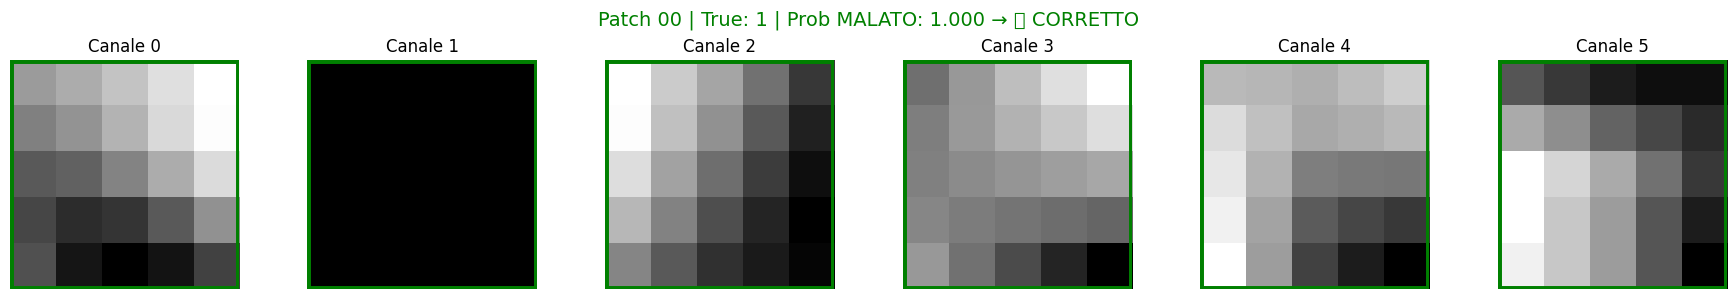

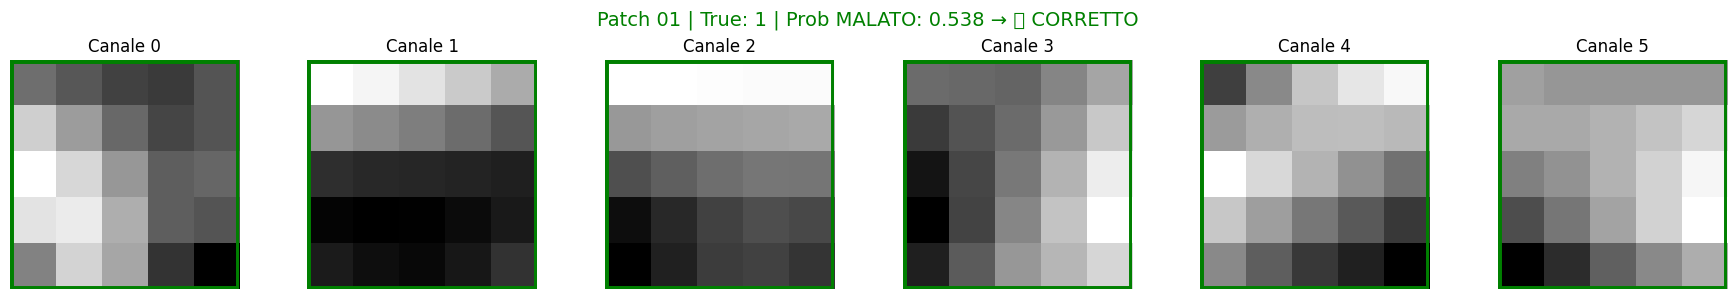

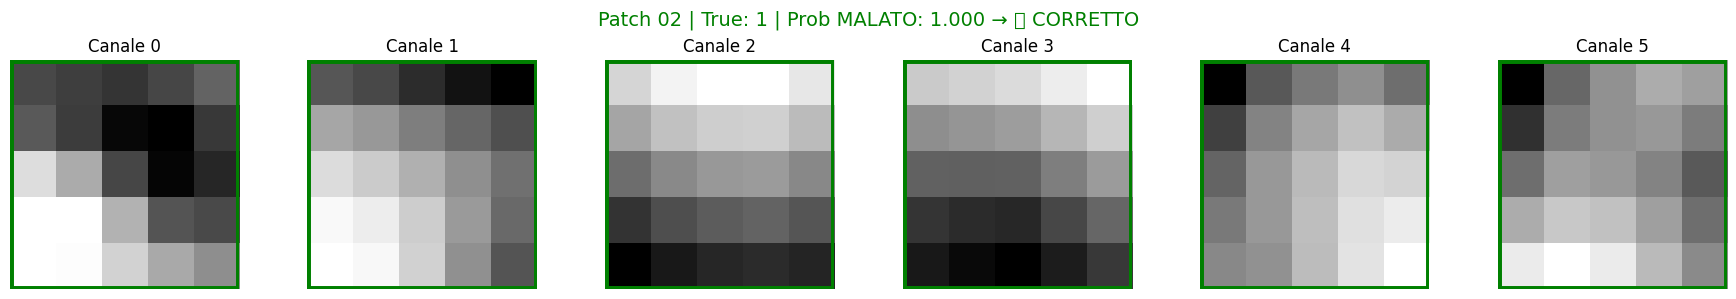

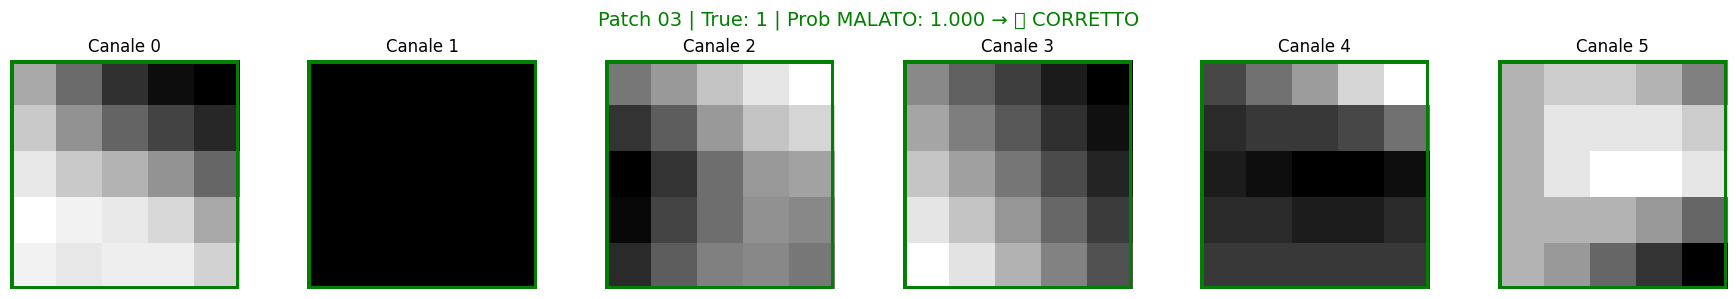

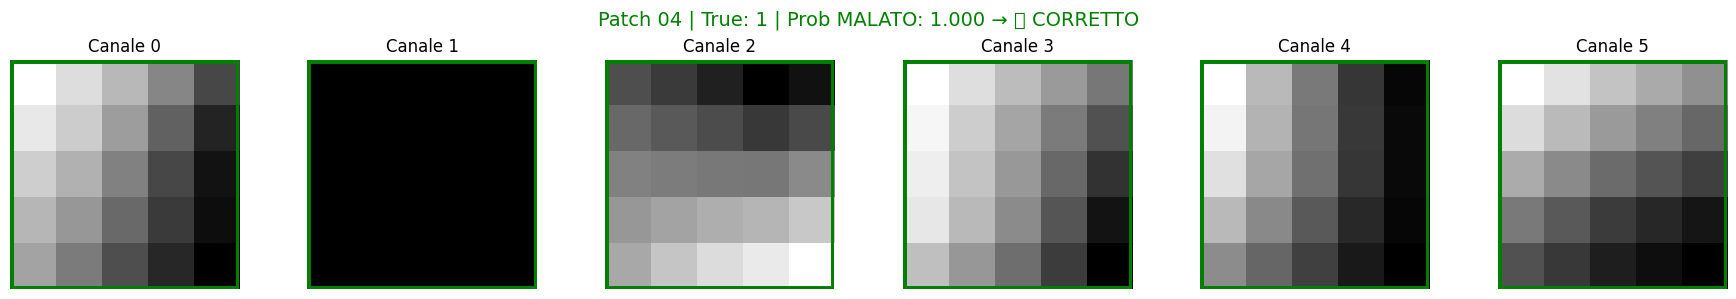

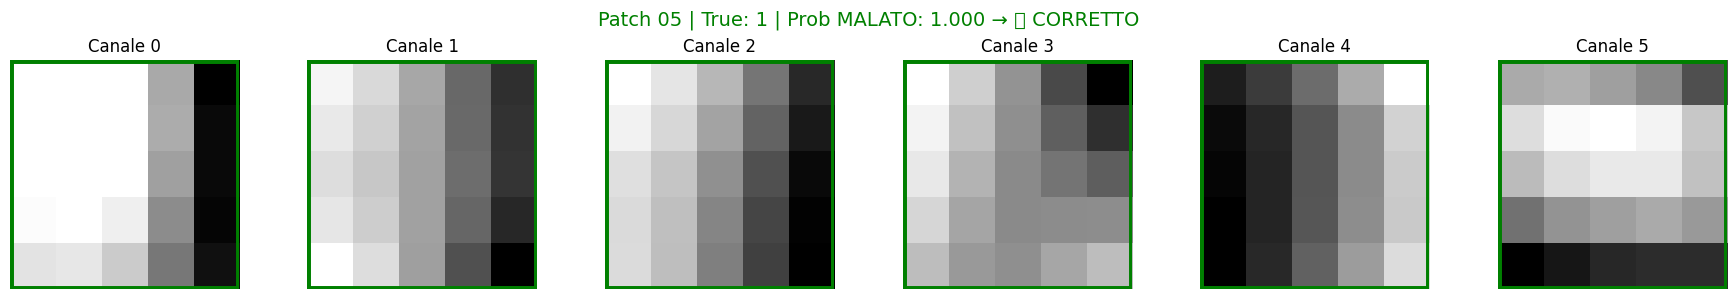

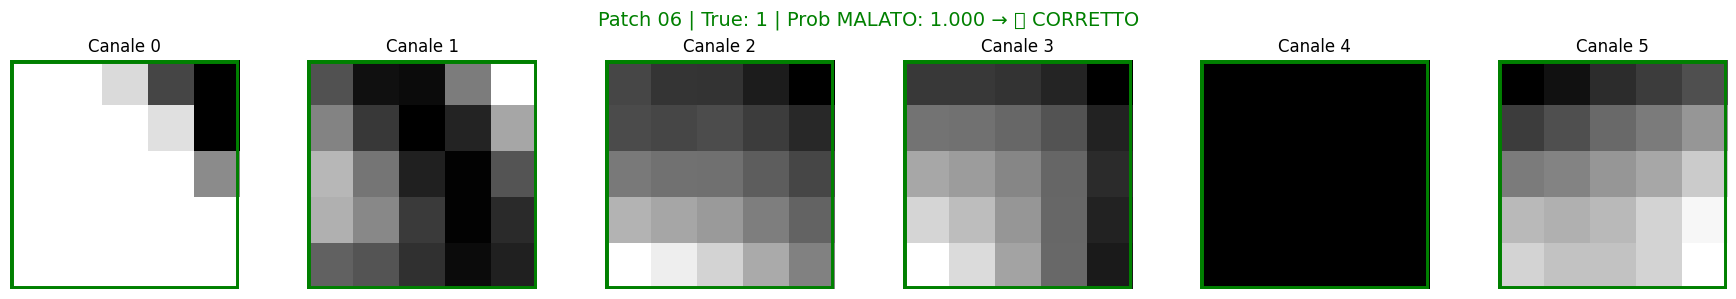

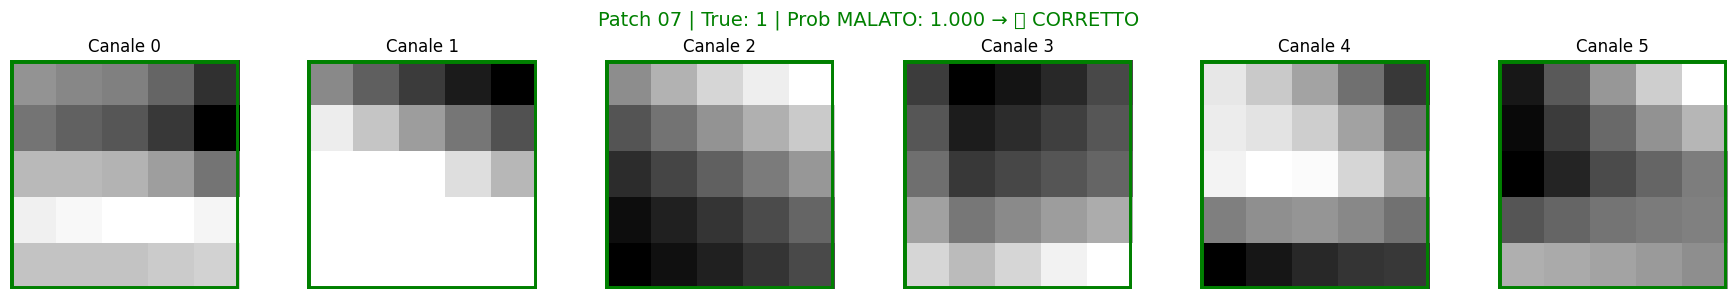

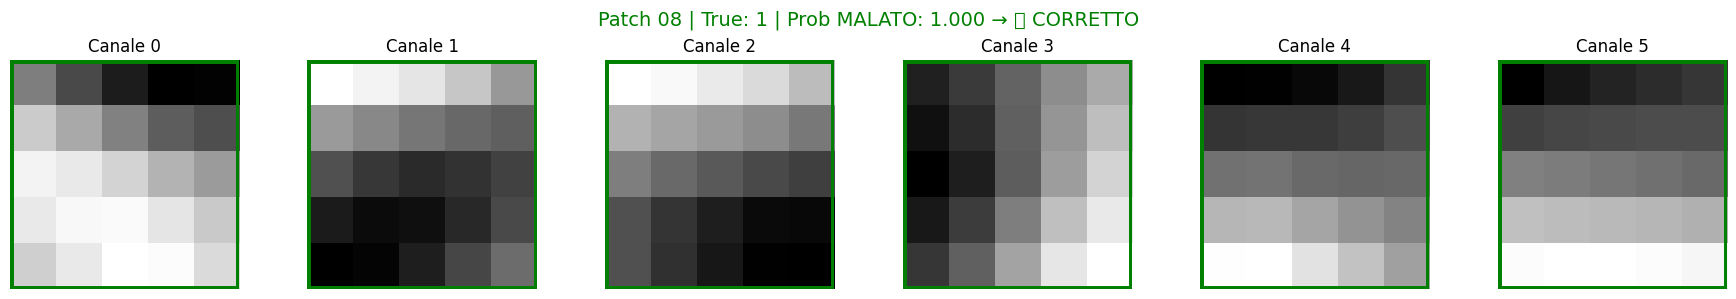

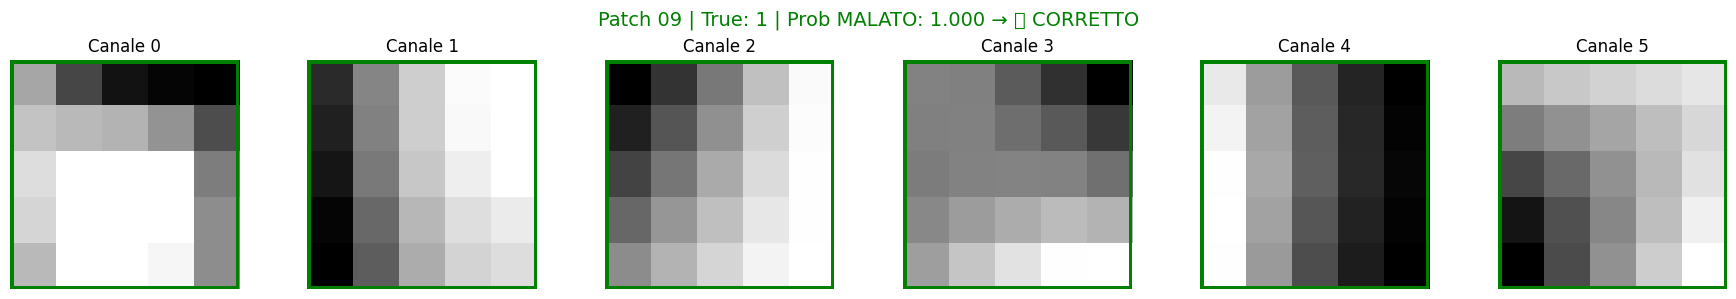

In [15]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

z_central = X.shape[2] // 2
threshold = 0.5  # soglia di classificazione

print("\n🔍 Visualizzo 10 patch con bordo colorato (verde = corretto, rosso = errato)")
for i in range(10):
    true_label = y_subset[i]
    pred_label = int(probs[i] >= threshold)
    corretto = (true_label == pred_label)

    colore_bordo = 'green' if corretto else 'red'
    stato = "✅ CORRETTO" if corretto else "❌ ERRATO"

    fig, axes = plt.subplots(1, X.shape[1], figsize=(3*X.shape[1], 3))
    for c in range(X.shape[1]):
        ax = axes[c]
        ax.imshow(X[idx_tot[i], c, z_central], cmap='gray')
        ax.set_title(f"Canale {c}")
        ax.axis('off')

        # Bordo colorato
        rect = patches.Rectangle((0, 0), 1, 1, transform=ax.transAxes,
                                 linewidth=5, edgecolor=colore_bordo,
                                 facecolor='none')
        ax.add_patch(rect)

    plt.suptitle(f"Patch {i:02d} | True: {true_label} | Prob MALATO: {probs[i]:.3f} → {stato}",
                 fontsize=14, color=colore_bordo)
    plt.tight_layout()
    plt.show()
